# Exploratory Data Analysing Using Youtube Video Data from Channels Related to Programming and Software Engineering

# 1. Aims, Objectives and Background

## 1.1. Introduction

Founded in 2005, Youtube has grown to become the second largest search engine in the world (behind Google) that processes more than 3 billion searches per month. [[1]](https://www.mushroomnetworks.com/infographics/youtube---the-2nd-largest-search-engine-infographic/). It is, however, generally a myth how the Youtube algorithm works, what makes a video get views and be recommended over another. In fact, YouTube has one of the largest scale and most sophisticated industrial recommendation systems in existence [[2]](https://dl.acm.org/doi/10.1145/2959100.2959190). For new content creators, it is a challenge to understand why a video gets video and others do not. There are many "myths" around the success of a Youtube video [[3]](https://vidiq.com/blog/post/5-youtube-algorithm-myths-youtubers-need-to-know-about/), for example if the video has more likes or comments, or if the video is of a certain duration. It is also worth experimenting and looking for "trends" in the topics that Youtube channels are covering in a certain niche.

As a System Information Engineering Student who right now is traning in Data Analysis and consuming Youtube Resources for learning, I decided to gain some insights on this topic which might be useful to put in practice the technical and theoretical knowledge seen during my career in college. The scope of this small project is limited to Programming and Software Engineering channels I follow and I will not consider other niches (that might have a different characteristics and audience base). Therefore, in this project I will explore the statistics of around 10 Youtube channels I'm subscribed to related to the world of IT.

## 1.2. Aims and Objectives

Within this project, I would like to explore the following:

- Getting to know Youtube API and how to obtain video data.
- Analyzing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
    - Does the number of likes and comments matter for a video to get more views?
    - Does the video duration matter for views and interaction (likes/ comments)?
    - Does title length matter for views?
    - How many tags do good performing videos have? What are the common tags among these videos?
    - Across all the creators I take into consideration, how often do they upload new videos? On which days in the week?
- Explore the trending topics using NLP techniques
    - Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
    - Which questions are being asked in the comment sections in the videos

## 1.3. Steps of the Project
1. Obtain video meta data via Youtube API for 10 channels in the IT niche (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
2. Prepocess data and engineer additional features for analysis
3. Exploratory data analysis
4. Conclusions

## 1.4. Dataset

### Data Selection

As this project is particularly focused on channels of my preferences, I found that not many readily available datasets online are suitable for this purpose. 

So, I created my own dataset using the [Google Youtube Data API version 3.0](https://developers.google.com/youtube/v3). The exact steps of data creation is presented in section *2. Data Creation* below.

### Data Limitations

The dataset is a real-world dataset and suitable for the research. However, the selection of the 10 Youtube channels to include in the research is purely based on my knowledge of the channels in IT field and might not be accurate. In addition, this is a personal analysis of channels that seems interested to me and I watch their content every day so there might be tons of other channels that might also very interesting to look into, which could be the next step of this project.

### Ethics of Data Source

According to [Youtube API's guide](https://developers.google.com/youtube/v3/getting-started), the usage of Youtube API is free of charge given that your application send requests within a quota limit. "The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others. " The default quota allocation for each application is 10,000 units per day, and you could request additional quota by completing a form to YouTube API Services if you reach the quota limit.

Since all data requested from Youtube API is public data (which everyone on the Internet can see on Youtube), there is no particular privacy issues as far as I am concerned. In addition, the data is obtained only for research purposes in this case and not for any commercial interests.

In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate
import os

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
from googleapiclient.discovery import build

In [2]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esposito\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\esposito\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Data creation with Youtube API

I first created a project on Google Developers Console, then requested an authorization credential (API key). Afterwards, I enabled Youtube API for my application, so that I can send API requests to Youtube API services. Then, I went on Youtube and checked the channel ID of each of the channels that I would like to include in my research scope (using their URLs). Then I created the functions for getting the channel statistics via the API.

In [3]:
# api_key = os.getenv('API_KEY')

channel_ids = ['UC7cs8q-gJRlGwj4A8OmCmXg', #Alex the Analyst
               'UC8butISFwT-Wl7EV0hUK0BQ', #freeCodeCamp
               'UCP15FVAA2UL-QOcGhy7-ezA', #EDteam
               'UC4FHiPgS1KXkUMx3dxBUtPg', #HolaMundo
               'UCGPGirOab9EGy7VH4IwmWVQ', #TravisMedia
               'UCLLw7jmFsvfIVaUFsLs8mlQ', #Luke Barousse
               'UCQSpnDG3YsFNf5-qHocF-WQ', #ThioJoe
               'UCtoo4_P6ilCj7jwa4FmA5lQ', #SoyDalto
               'UCjXAQ-cayM4mIZmUZKMFW_w', #Programador X
               'UC55-mxUj5Nj3niXFReG44OQ'  #Platzi
              ]

youtube = build('youtube', 'v3', developerKey=api_key)

In [4]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

### Get Channel Statistics

Using the `get_channel_stats` function defined below, now we are going to obtain the channel statistics for the 10 channels in scope.

In [5]:
channel_data = get_channel_stats(youtube, channel_ids)

Now I can print out the data and take a look at the channel statistics overview.

In [6]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Alex The Analyst,646000,27484545,269,UU7cs8q-gJRlGwj4A8OmCmXg
1,Programador X,299000,13259564,181,UUjXAQ-cayM4mIZmUZKMFW_w
2,Platzi,1710000,231302824,2421,UU55-mxUj5Nj3niXFReG44OQ
3,EDteam,685000,42702303,463,UUP15FVAA2UL-QOcGhy7-ezA
4,Luke Barousse,397000,19134933,147,UULLw7jmFsvfIVaUFsLs8mlQ
5,HolaMundo,710000,40530660,343,UU4FHiPgS1KXkUMx3dxBUtPg
6,Soy Dalto,786000,41852552,183,UUtoo4_P6ilCj7jwa4FmA5lQ
7,Travis Media,153000,7085402,200,UUGPGirOab9EGy7VH4IwmWVQ
8,ThioJoe,3030000,247278587,870,UUQSpnDG3YsFNf5-qHocF-WQ
9,freeCodeCamp.org,8790000,637880677,1558,UU8butISFwT-Wl7EV0hUK0BQ


I noticed the count columns in `channel_data` is currently in string format, so I will convert them into numeric so that we can visualize and do numeric operations on them.

In [7]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.

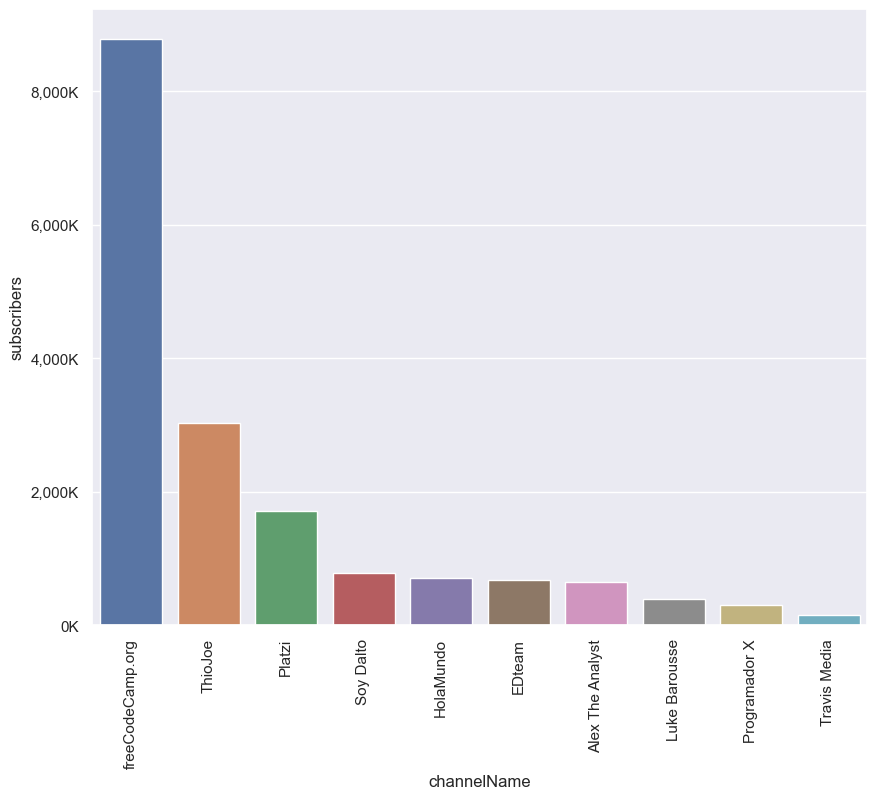

In [38]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Next, we will look at the rank considering the total number of views of the channels. The rank is fairly similar to the subscriber count rank. freeCodeCamp and ThioJoe remain the two channels with most subscribers and views

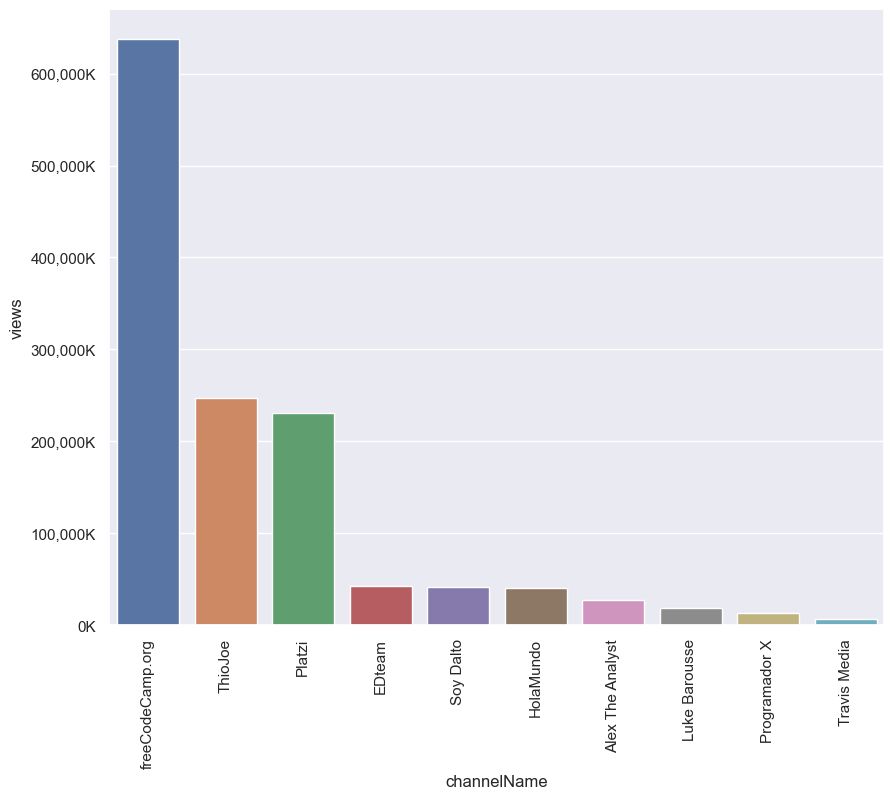

In [9]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Interestingly, some channels have more subscribers but less views and vice versa. For example, SoyDalto has significantly more subscribers than EDteam channel, but slightly less views in total.

### Get video statistics for all the channels

In the next step, we will obtain the video statistics for all the channels. In total, we obtained 6623 videos as seen in below.

In [10]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = video_df.append(video_data, ignore_index=True)
    comments_df = comments_df.append(comments_data, ignore_index=True)

Getting video information from channel: Alex The Analyst


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Programador X


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Platzi
Could not get comments for video zl953k4DNq8
Could not get comments for video eyxvplarEJE
Could not get comments for video qKmFgdD4OrA


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: EDteam
Could not get comments for video JID-RKoiG4E
Getting video information from channel: Luke Barousse


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Could not get comments for video r9imv1z82jQ


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: HolaMundo
Could not get comments for video laeDD_YB9xM


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Soy Dalto


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Travis Media


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: ThioJoe


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: freeCodeCamp.org
Could not get comments for video sQxL1bz7Iqs


C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\esposito\AppData\Local\Temp\ipykernel_5936\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


In [11]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,qPOmj22QX04,Alex The Analyst,Practice SQL and Python right on your Phone!,,None,2023-12-13T16:12:42Z,3511,314,None,12,PT28S,hd,false
1,XD1ul5fpnGI,Alex The Analyst,Analyst Builder Full Launch! | The Learning Pl...,Try out Analyst Builder Today! https://www.ana...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-12T13:00:21Z,7720,410,None,47,PT16M27S,hd,false
2,kifhSqep9UM,Alex The Analyst,Analyst Builder Full Launch LiveStream | 20% O...,Try out Analyst Builder Today! https://www.ana...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-11T19:04:05Z,10349,466,None,9,PT4H34M24S,hd,false
3,dCNjUOc1cBY,Alex The Analyst,Having vs Where in MySQL | Beginner MySQL Series,Full MySQL Course: https://www.analystbuilder....,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-05T13:00:35Z,4858,188,None,14,PT3M46S,hd,false
4,lEjmgE-hogg,Alex The Analyst,#Excel is Frustrating,,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-11-29T18:00:02Z,4407,293,None,9,PT47S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6618,_uWzpyr_5qk,freeCodeCamp.org,Computer Basics 5: How To Measure Data Size,http://FreeCodeCamp.com is a community of busy...,"[Free Code Camp, JavaScript, Pair Programming,...",2015-07-17T08:31:23Z,54573,None,None,40,PT2M24S,hd,false
6619,xXLj5MbrI44,freeCodeCamp.org,Computer Basics 4: Decoding a Binary Number,http://FreeCodeCamp.com is a community of busy...,"[Free Code Camp, JavaScript, Pair Programming,...",2015-07-17T08:31:20Z,72338,None,None,39,PT1M42S,hd,true
6620,veugT7A9psY,freeCodeCamp.org,Computer Basics 3: Intro to Binary Code,http://FreeCodeCamp.com is a community of busy...,"[Free Code Camp, JavaScript, Pair Programming,...",2015-07-17T08:31:17Z,60502,None,None,13,PT1M,hd,true
6621,xj9mFD71Vfc,freeCodeCamp.org,Computer Basics 2: More Computer Hardware,http://FreeCodeCamp.com is a community of busy...,"[Free Code Camp, JavaScript, Pair Programming,...",2015-07-17T08:31:14Z,70759,None,None,18,PT1M12S,hd,true


Let's take a look at the `comment_df` as well. We only get 6616 comments in total due to the fact that we limited to 10 first comments on the video to avoid exceeding the Youtube API quota limit.

In [12]:
comments_df

,video_id,comments
0,qPOmj22QX04,"[Nice work Alex, Hope to get it app soon, well..."
1,XD1ul5fpnGI,[Can you please make a video of the recession ...
2,kifhSqep9UM,[Sorry I had a question I’m very interested in...
3,dCNjUOc1cBY,"[Alex or anybody here, I need help! Anybody ha..."
4,lEjmgE-hogg,[I might make a thousand bucks from the amount...
...,...,...
6611,_uWzpyr_5qk,"[Nice 👍🏻, At school I learned that the Bit is ..."
6612,xXLj5MbrI44,"[Lovely, Is it compulsory to take no:2 ?? Or c..."
6613,veugT7A9psY,"[Watching in 2023 😅, following., #03, Beauty w..."
6614,xj9mFD71Vfc,"[black, This is a great course series, with a ..."


In [13]:
# Write video data to CSV file for future references
video_df.to_csv('video_data_top10_channels.csv')
comments_df.to_csv('comments_data_top10_channels.csv')

## Preprocessing & Feature Engineering

To be able to make use of the data for analysis, we need to perform a few pre-processing steps. Firstly, I would like reformat some columns, especially the date and time columns such as "pushlishedAt" and "duration". In addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the videos' characteristics.

### Check for Empty Values

In [14]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

There's no strange dates in the publish date column, videos were published between 2016 and 2023.

In [15]:
video_df.publishedAt.sort_values().value_counts()

2018-09-15T22:36:04Z    27
2018-11-05T02:27:46Z    17
2019-01-16T23:29:44Z     8
2016-09-23T15:59:27Z     4
2016-09-23T15:59:26Z     4
                        ..
2018-06-14T14:06:41Z     1
2018-06-13T22:52:23Z     1
2018-06-13T17:10:11Z     1
2018-06-13T15:03:50Z     1
2023-12-16T16:37:55Z     1
Name: publishedAt, Length: 6545, dtype: int64

Next, we need to check if the data type of the columns are correct. I have checked the data types and indeed some count columns such as view count and comment count are currently not in correct data type. In this step, we convert these count columns into integer.

In [16]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

### Enriching Data

I want to enrich the data for further analyses, for example:

- create published date column with another column showing the day in the week the video was published, which will be useful for later analysis.

- convert video duration to seconds instead of the current default string format

- calculate number of tags for each video

- calculate comments and likes per 1000 view ratio

- calculate title character length

In [17]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [18]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [19]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [20]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [21]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

Let's look at the video dataset at this point to see if everything went well. It looks good - now we will proceed to exploratory analysis part.

In [22]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,qPOmj22QX04,Alex The Analyst,Practice SQL and Python right on your Phone!,,None,2023-12-13 16:12:42+00:00,3511.0,314.0,NaN,12.0,PT28S,hd,false,Wednesday,28.0,0,89.433210,3.417830,44
1,XD1ul5fpnGI,Alex The Analyst,Analyst Builder Full Launch! | The Learning Pl...,Try out Analyst Builder Today! https://www.ana...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-12 13:00:21+00:00,7720.0,410.0,NaN,47.0,PT16M27S,hd,false,Tuesday,987.0,5,53.108808,6.088083,76
2,kifhSqep9UM,Alex The Analyst,Analyst Builder Full Launch LiveStream | 20% O...,Try out Analyst Builder Today! https://www.ana...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-11 19:04:05+00:00,10349.0,466.0,NaN,9.0,PT4H34M24S,hd,false,Monday,16464.0,5,45.028505,0.869649,65
3,dCNjUOc1cBY,Alex The Analyst,Having vs Where in MySQL | Beginner MySQL Series,Full MySQL Course: https://www.analystbuilder....,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-12-05 13:00:35+00:00,4858.0,188.0,NaN,14.0,PT3M46S,hd,false,Tuesday,226.0,5,38.699053,2.881844,48
4,lEjmgE-hogg,Alex The Analyst,#Excel is Frustrating,,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-11-29 18:00:02+00:00,4407.0,293.0,NaN,9.0,PT47S,hd,false,Wednesday,47.0,5,66.485137,2.042206,21


## Exploratory Analysis

### Views distribution per channel

With the video statistics for all channel, now we can see how the views are distributed per channel. Some channels might have a lot of views on one of their videos and the rest do not receive many views. Other channels might have more evenly distribution views per video. It can be observed that freeCodeCamp and ThioJoe have quite large variance in their views, suggesting that they have a few viral videos. The rest of the channels have less views overall but the views are more consistent across videos. 

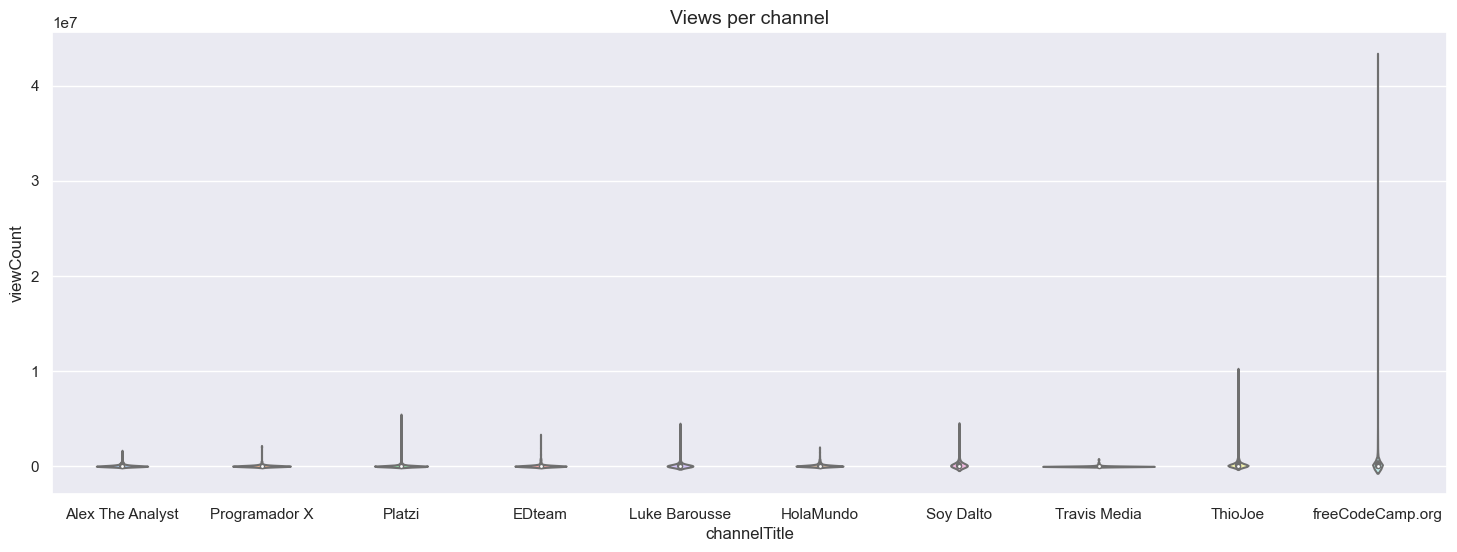

In [23]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x=video_df['channelTitle'],y= video_df['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

### Does the number of likes and comments matter for a video to get more views?

Firstly, I would like to check if comments and likes do correlate with how many views a video would get. In the plots below, it can be observed that the number of views and number of comments/ likes strongly correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. To correct for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.

<AxesSubplot: xlabel='likeCount', ylabel='viewCount'>

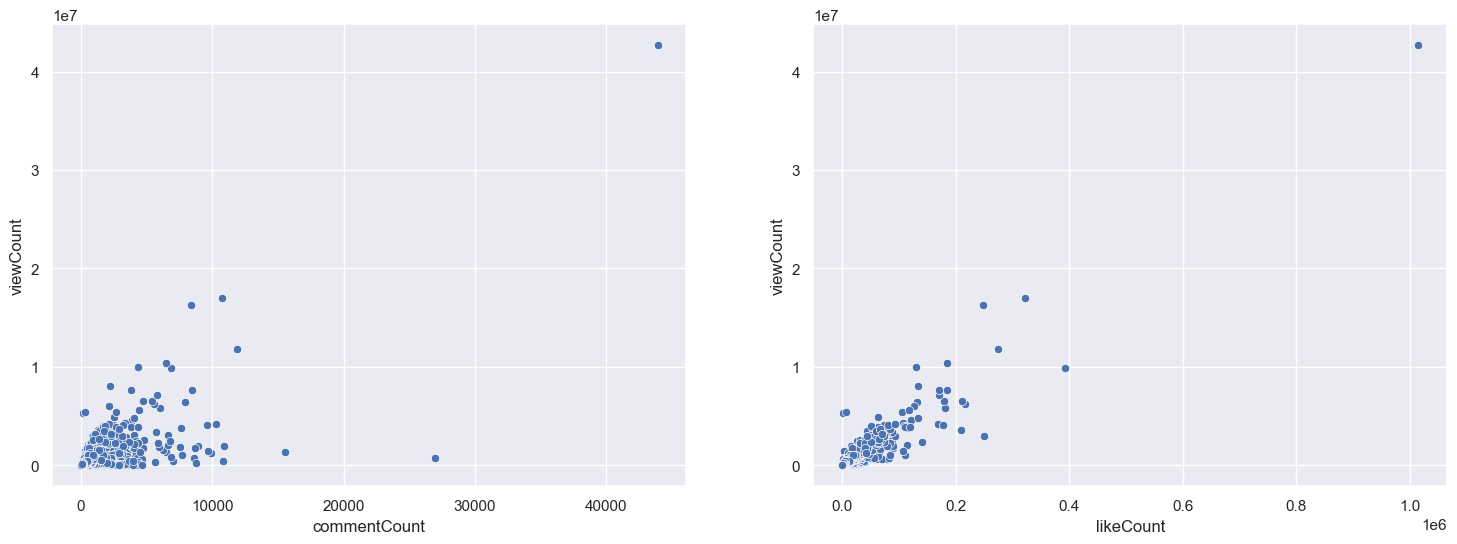

In [24]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number.

<AxesSubplot: xlabel='likeRatio', ylabel='viewCount'>

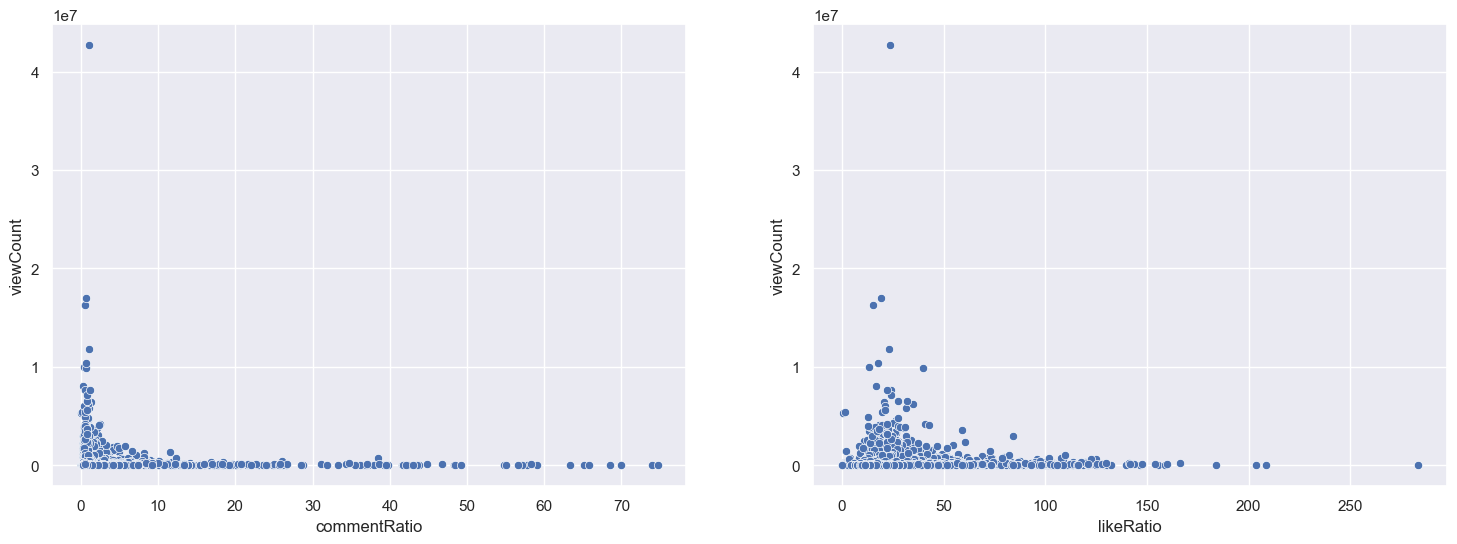

In [25]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

After correcting for the absolute number of views, it turns out that the correlation is much less clear. The comment-view relationship seems to completely disappear: a lot of videos have millions of views and very few comments, while some videos have very few views and have more comments. However, it is understandable that comments take more effort than views and likes, and normally comments would die off when the video gets older.

As for like-view relatioship, we can still see some positive correlation between views and like ratio, which means that the more views a video has, the more people would hit the like button. This seems to support the idea of social proof, which means that people tend to like better the products that are already liked by many other people.

#### Does the video duration matter for views and interaction (likes/ comments)?

As can be seen in the histogram below, most videos are between 400 to 1200 seconds, which is about 5 to 20 minutes. Here I have to limit the duration to 10,000 because of some really long videos (potentially streaming videos). 

<AxesSubplot: xlabel='durationSecs', ylabel='Count'>

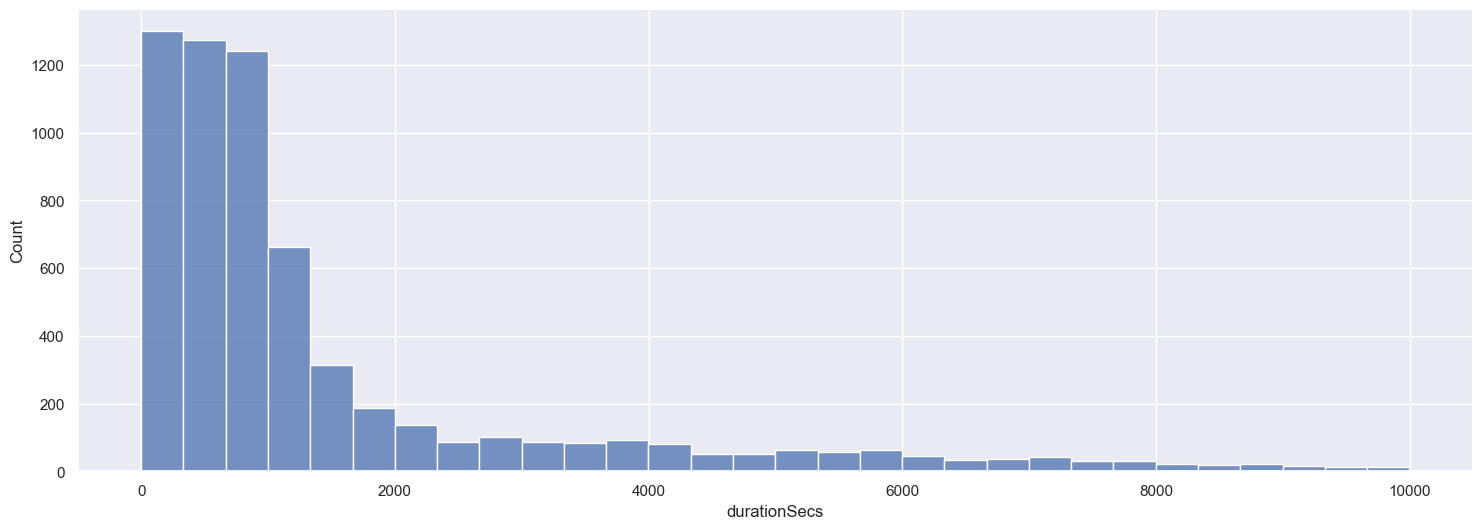

In [26]:
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)

Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos.

<AxesSubplot: xlabel='durationSecs', ylabel='likeCount'>

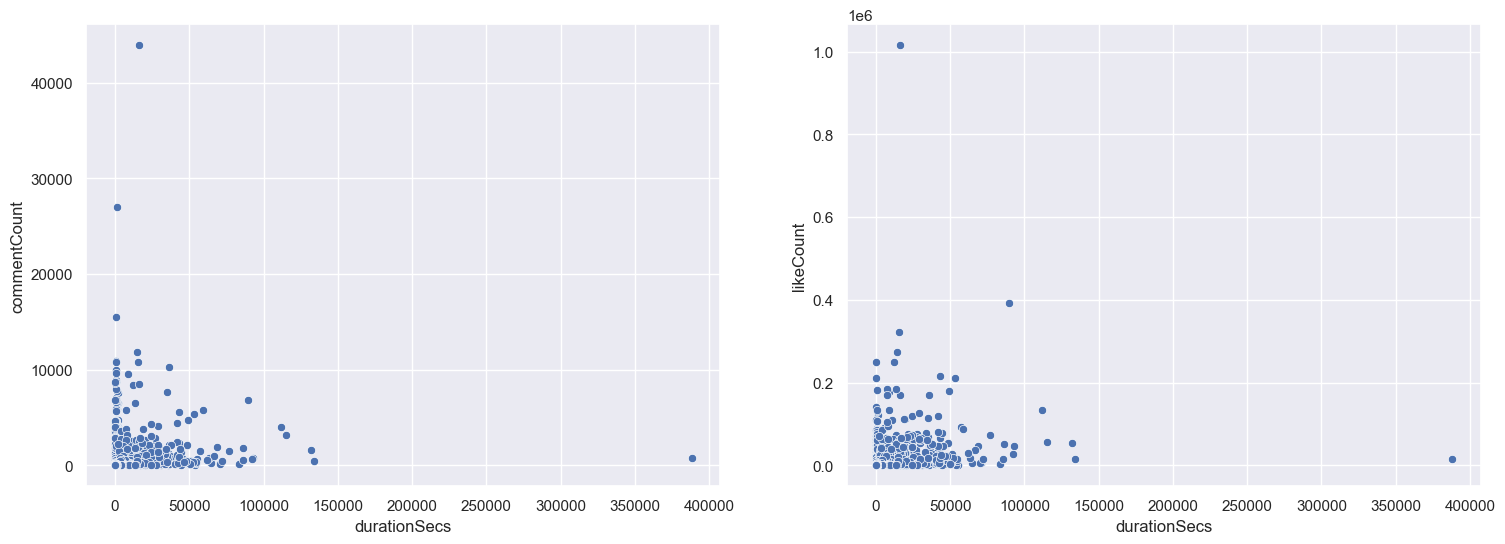

In [27]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

### Does title length matter for views?

There is no clear relationship between title length and views as seen the scatterplot below, but most-viewed videos tend to have average title length of 30-70 characters.

<AxesSubplot: xlabel='titleLength', ylabel='viewCount'>

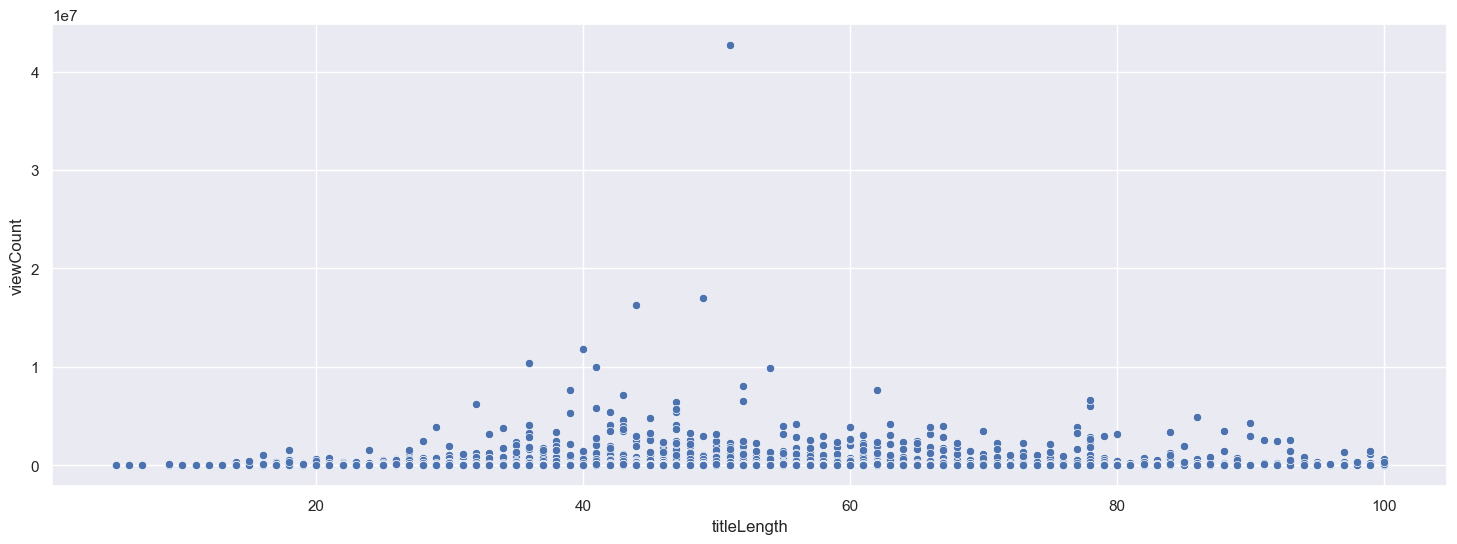

In [28]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

### Wordcloud for words in title

As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words. We first need to remove the stopwords such as "you", "I", "the", etc and also the ones corresponding to the spanish words as there are channels with spanish as target language which do not contribute a lot to the meaning of the title.

In [29]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

In [30]:
stop_words = set(stopwords.words('spanish'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

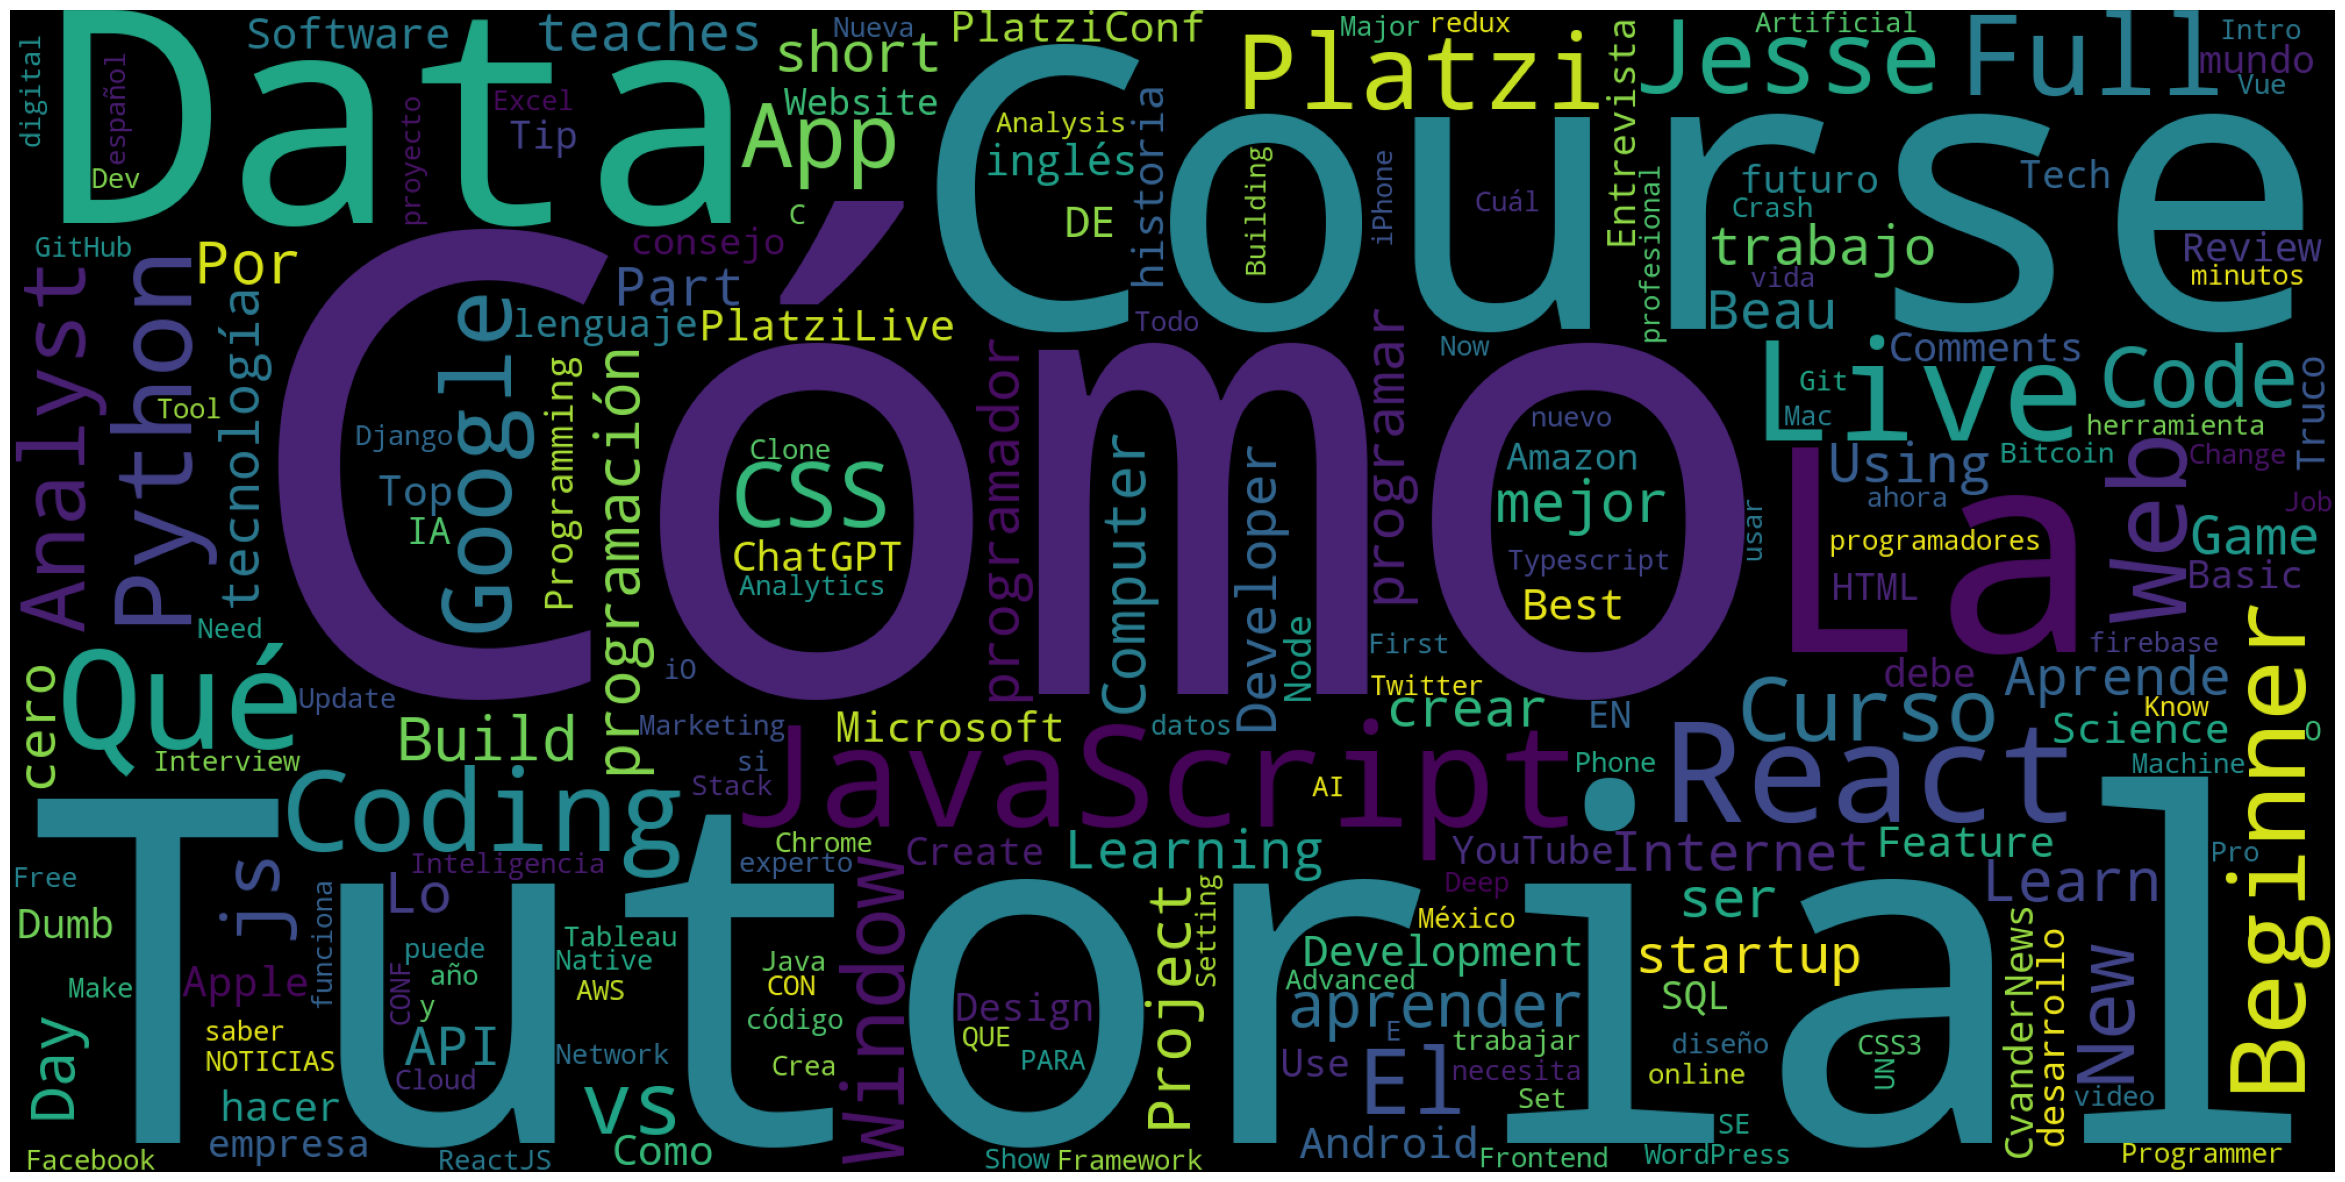

In [31]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

It can be seen that most common words are Data, Cómo, Tutorial, Course,  Platzi, Coding, Programming, Python, which is expected.

### Number of tags vs views

It seems that most videos have between 5 and 30 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.

<AxesSubplot: xlabel='tagsCount', ylabel='viewCount'>

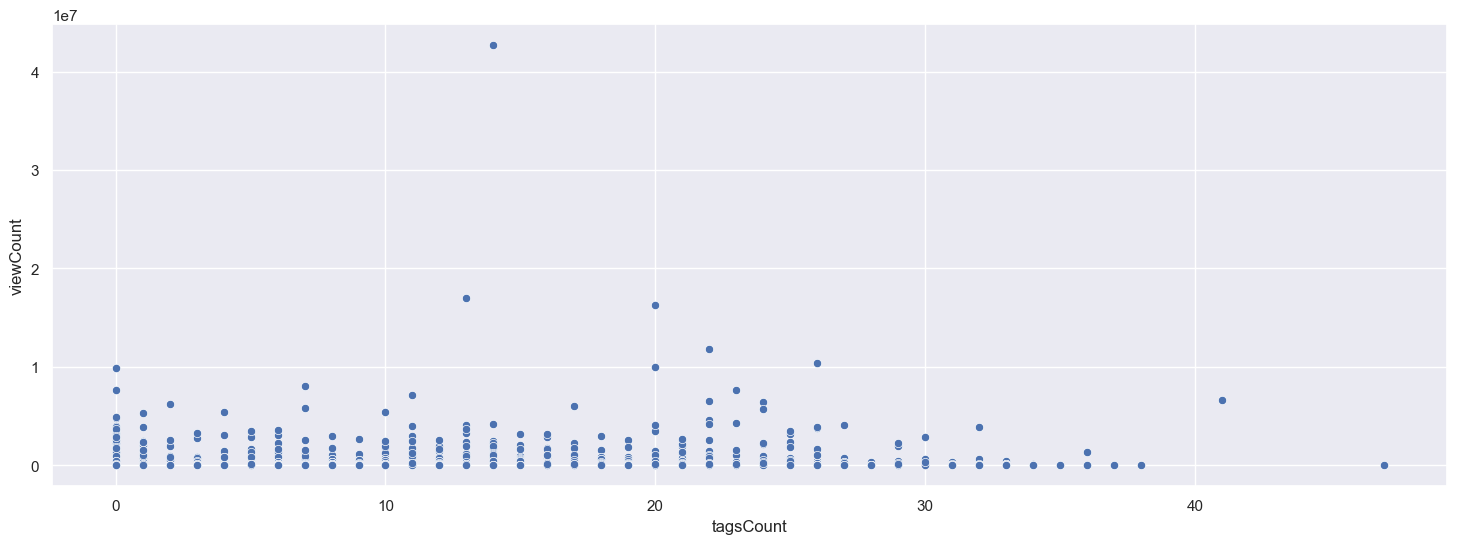

In [32]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

### Which day in the week are most videos uploaded?

It's interesting to see that more videos are uploaded on Mondays and Fridays. Fewer videos are uploaded during the weekend. This could be because of the nature of the niche that is more geared towards tutorials and heavy materials, which is not suitable for weekends' consumption. But it could also just means that most creators work on their videos during the weekend or during the week and upload them beginning of the week or Friday.

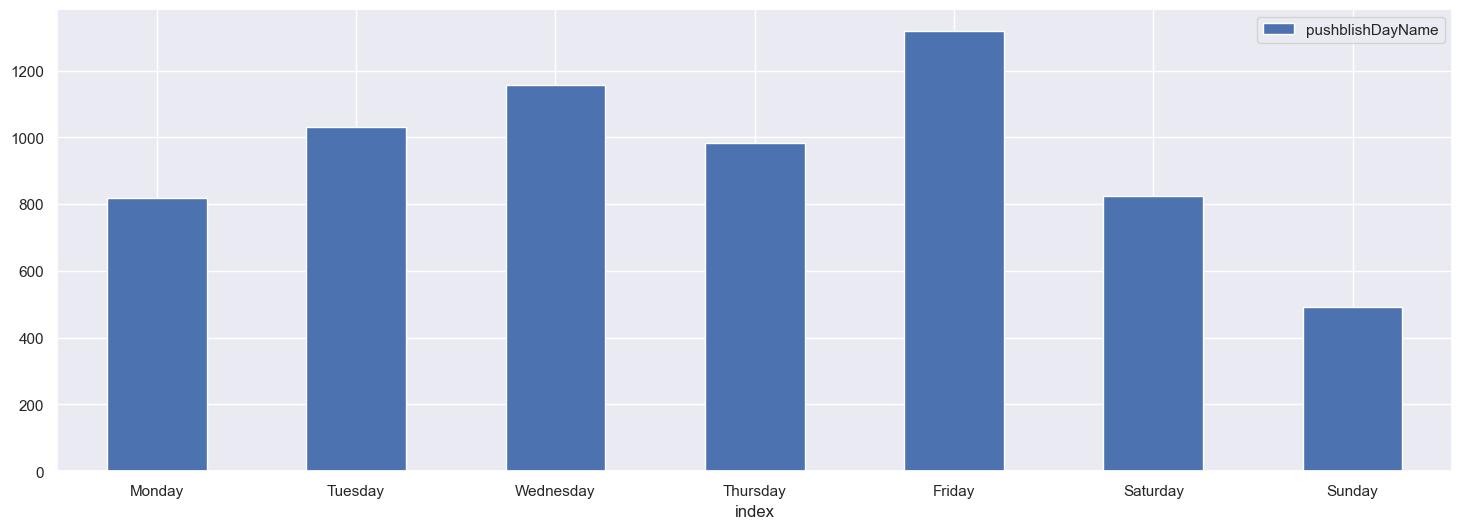

In [33]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

### Wordcloud for video comments

We can see what are the frequently-mentioned words in the video comments. I will do this by visualizing the keywords in a wordcloud.

In [34]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

In [35]:
stop_words = set(stopwords.words('spanish'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

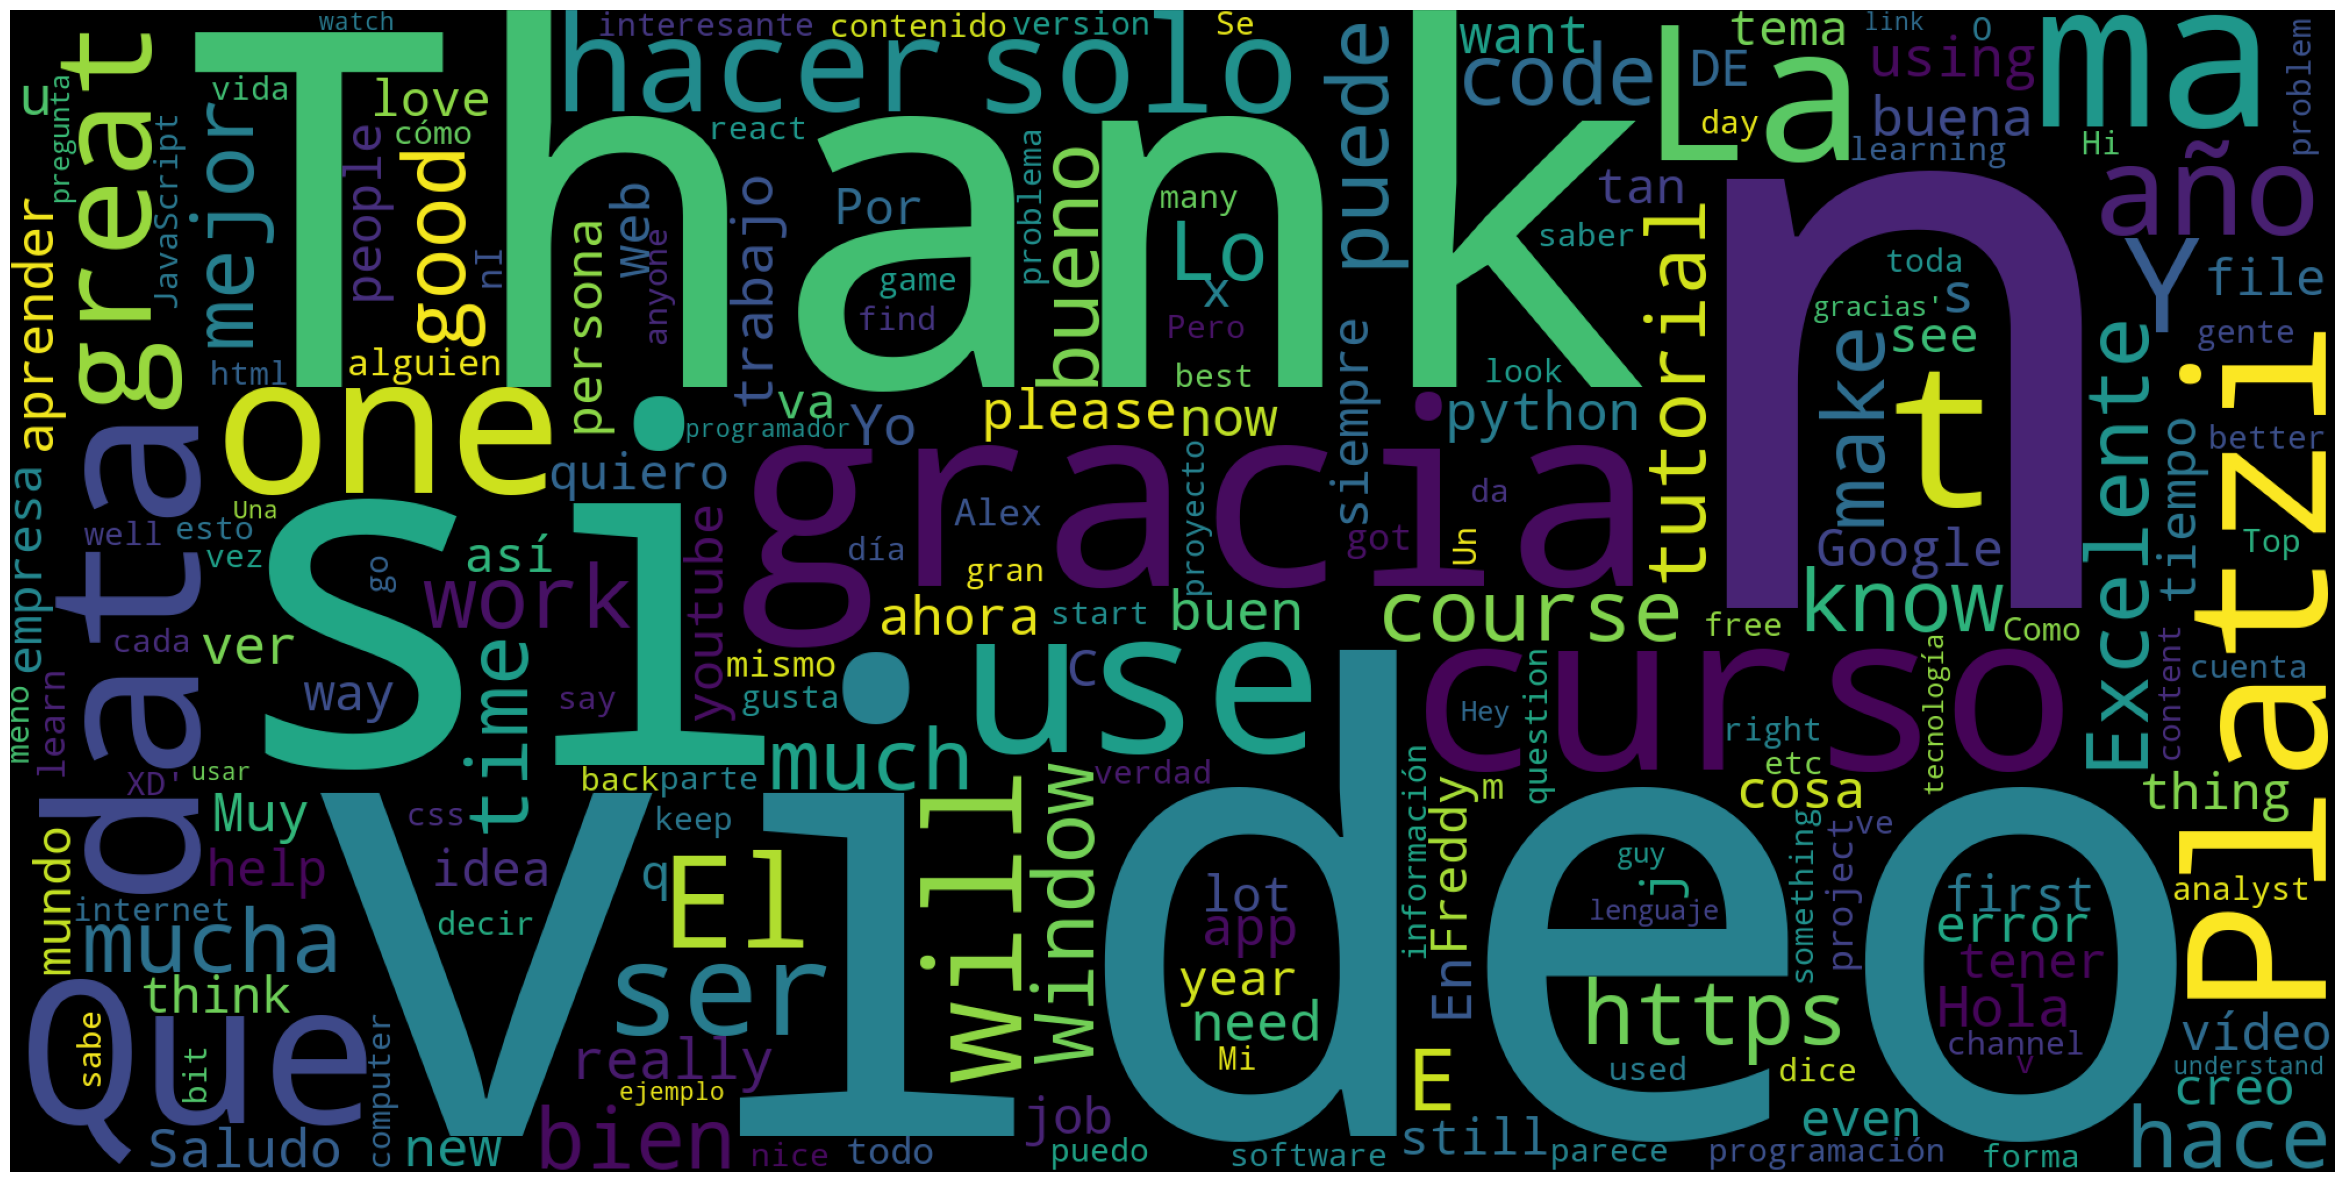

In [36]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

We can see that next to the obvious words such as "video", "data", the most frequent words are quite positive, such as "thank", "gracia", "great", "use", "si". A lot of comments also request something with the word "curso".

## Conclusions and Future Research Ideas

In this project, we have explored the video data of 10 Youtube channels I follow on and revealed many interesting findings for anyone who are starting out with a Youtube channel in IT or another topic:

- The more likes and comments a video has, the more views the video gets (it is not guaranteed that this is a causal relationship, it is simply a correlation and can work both way). Likes seem to be a better indicator for interaction than comments and the number of likes seem to follow the "social proof", which means the more views the video has, the more people will like it.

- Most videos have between 5 and 30 tags.

- Most-viewed videos tend to have average title length of 30-70 characters. Too short or too long titles seem to harm viewership.

- Videos are usually uploaded on Mondays and Fridays. Weekends and Sunday in particular is not a popular time for posting new videos.

- Comments on videos are generally positive, we noticed a lot "curso" words, suggesting potential market gaps in content that could be filled. 

**Project limitation:**

The findings should also be taken with a grain of salt for a number of reasons:

- The number of videos is quite small (the dataset has only ~6623 videos)

- I have only considered the first 10 comments on each video, which might not be representative for all comments

- There are many other factors that haven't been taken into the analysis, including the marketing strategy of the creators and many random effects that would affect how successful a video is

**Ideas for future research:**

To expand and build on this research project, one can:

- Expand the dataset to also smaller channels in Programming/Software Engineering niche

- Do sentiment analysis on the comments and find out which videos get more positive comments and which videos get less positive comments

- Do market research by analyzing questions in the comment threads and identifying common questions/ market gaps which could potentially filled

- Conduct this research for other niches (e.g. vlogs or gaming channels), to compare different niches with each other to see the different patterns in viewership and video characteristics.

### References/ Resources used:

[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Converting video durations to time function. https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3

[3] P. Covington, J. Adams, E. Sargin. The youtube video recommendation system. In Proceedings of the Fourth ACM Conference on Recommender Systems, RecSys '16, pages 191-198, New York, NY, USA, 2016. ACM.